In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
import tflearn
import tensorflow as tf
import gc

from PCA import PCA
from kernelPCA import kernelPCA
from classify import classification

%matplotlib inline

In [2]:
# Data loading and preprocessing
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/', one_hot=True)

# get detailed data
train_img = mnist.train.images
train_label = mnist.train.labels

cv_img = mnist.validation.images
cv_label = mnist.validation.labels

test_img = mnist.test.images
test_label = mnist.test.labels

train_single_label = np.argmax(train_label, axis=1)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
# define colors
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#7FFFD4', '#9ACD32', '#FFA500']

# Build the PCA model

In [4]:
pca = PCA()
pca.fit(train_img)
train_pca = pca.transform(train_img)
cv_pca = pca.transform(cv_img)
test_pca = pca.transform(test_img)

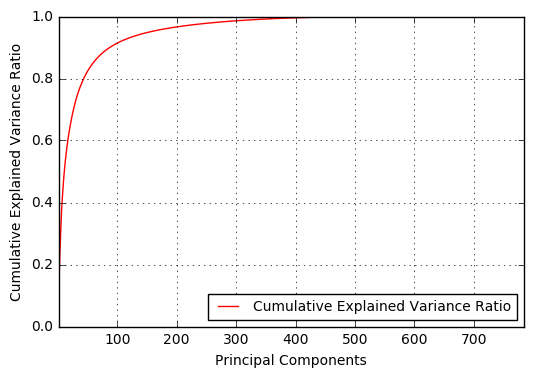

In [5]:
# # show the change of explained variance ratio and cumulative ratio
# ratio = pca.variance / np.sum(pca.variance)
# cdf = np.cumsum(pca.variance) / np.sum(pca.variance)

# # explained variance
# n = 784
# fig, ax = plt.subplots()
# # ax.plot(range(1, n+1), ratio[:n], 'g-')
# ax.plot(range(1, n+1), cdf[:n], 'r-', label='Cumulative Explained Variance Ratio')
# ax.set_xlim([1, n])
# ax.set_xlabel('Principal Components')
# ax.set_ylabel('Cumulative Explained Variance Ratio')
# ax.grid('on')
# ax.legend(fontsize=10, loc=4)
# fig.savefig('./result/cdf.pdf')
# fig.savefig('./result/cdf.png', dpi=300)
# plt.show()

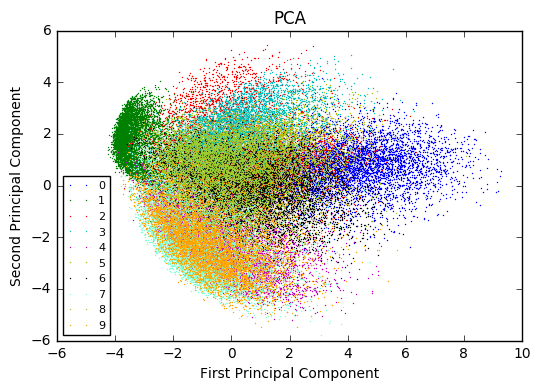

In [6]:
# visualize the PCA projections
fig, ax = plt.subplots()
for i in range(10):
    tmp = train_pca[train_single_label == i, :2]
    plt.plot(tmp[:, 0], tmp[:, 1], '.', color=colors[i], markersize=1, label=str(i))
ax.set_title('PCA')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend(fontsize=8, loc='best')
fig.savefig('./result/pca.pdf')
fig.savefig('./result/pca.png', dpi=300)
plt.show()

# Build the kernel PCA model

* Warning: the following code will use a lot of memory, CPU and local space
* To run the code, it is highly suggested to run using only a subset data

In [7]:
# kernel PCA for polynomial kernel from 2 to 10 degrees, save fitted data to local
folder = '/media/jifu/F268088F680854AF/ECE544_Data/KernelPCA/'
for degree in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    kpca = KernelPCA(kernel='poly', gamma=None, degree=degree, n_jobs=6)
    kpca.fit(train_img[:20000, :])

    train_kpca = kpca.transform(train_img)
    cv_kpca = kpca.transform(cv_img)
    test_kpca = kpca.transform(test_img)
    
    train_path = folder + str(degree) + 'train_kpca' + str(degree) + '.npy'
    cv_path = folder + str(degree) + 'cv_kpca' + str(degree) + '.npy'
    test_path = folder + str(degree) + 'test_kpca' + str(degree) + '.npy'

    np.save(train_path, train_kpca)
    np.save(cv_path, cv_kpca)
    np.save(test_path, test_kpca)

    del [train_kpca, test_kpca]
    gc.collect()

In [8]:
# train_kpca = np.load('/media/jifu/F268088F680854AF/ECE544_Data/KernelPCA/train_kpca2.npy')

# # visualize the kernel PCA projections
# fig, ax = plt.subplots()
# for i in range(10):
#     tmp = train_kpca[train_single_label == i, :2]
#     plt.plot(tmp[:, 0], tmp[:, 1], '.', color=colors[i], markersize=1, label=str(i))
# ax.set_title('kernel PCA')
# ax.set_xlabel('First Principal Component')
# ax.set_ylabel('Second Principal Component')
# ax.legend(fontsize=8, loc='best')
# fig.savefig('./result/kpca.pdf')
# fig.savefig('./result/kpca.png', dpi=300)
# plt.show()

# del [train_kpca]
# gc.collect()

# Classification

## PCA model

In [10]:
with open('./result/PCA.txt', 'w') as f:
    f.write('PCA model\n')
    n_list = [16, 32, 64, 128, 256, 512, 784]
    for n_feature in n_list:
        train_acc, test_acc = classification(train_pca, train_label, test_pca, test_label, 
                                             dim_input=n_feature, dim_output=10, 
                                             cv_x=cv_pca, cv_y=cv_label, n_epoch=20)
        
        f.write('{0:8d} features, training accuracy is {1:5f}, test accuracy is {2:5f}\n'\
                .format(n_feature, train_acc, test_acc))

print('Classification for PCA is finished, result is written into ./result/PCA.txt !')

Training Step: 17200  | total loss: 0.21321
| Adam | epoch: 020 | loss: 0.21321 | val_loss: 0.26941 -- iter: 55000/55000
Training Step: 17200  | total loss: 0.21321
| Adam | epoch: 020 | loss: 0.21321 | val_loss: 0.26941 -- iter: 55000/55000
--
Classification for PCA is finished, result is written into ./result/PCA.txt !


## Kernel PCA model

In [11]:
folder = '/media/jifu/F268088F680854AF/ECE544_Data/KernelPCA/'
n_list = [32, 64, 128, 256, 512, 784, 1024, 2048, 4096, 8192, 16384]
degree_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

with open('./result/kernelPCA.txt', 'w') as f:
    for degree in degree_list:    
        f.write('Kernel PCA model with degree ' + str(degree) + '\n')

        train_name = folder + 'train_kpca' + str(degree) + '.npy'
        cv_name = folder + 'cv_kpca' + str(degree) + '.npy'
        test_name = folder + 'test_kpca' + str(degree) + '.npy'
        
        train_kpca = np.load(train_name)
        cv_kpca = np.load(cv_name)
        test_kpca = np.load(test_name)

        for n_feature in n_list:
            train_acc, test_acc = classification(train_kpca, train_label, test_kpca, test_label,
                                                 dim_input=n_feature, dim_output=10, n_epoch=20, 
                                                 cv_x=cv_kpca, cv_y=cv_label)
            f.write('{0:8d} features, training accuracy is {1:5f}, test accuracy is {2:5f}\n'\
                    .format(n_feature, train_acc, test_acc))

        del [train_kpca, cv_kpca, test_kpca]
        gc.collect()
        
print('Classification for kernel PCA is finished, result is written into ./result/kernelPCA.txt !')

Training Step: 17200  | total loss: 0.11227
| Adam | epoch: 020 | loss: 0.11227 | val_loss: 0.09368 -- iter: 55000/55000
Training Step: 17200  | total loss: 0.11227
| Adam | epoch: 020 | loss: 0.11227 | val_loss: 0.09368 -- iter: 55000/55000
--
Classification for kernel PCA is finished, result is written into ./result/kernelPCA.txt !
